NEW TRY

In [1]:
import torch
from torch_geometric.data import Data, Dataset
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

from Datasets.synthetics import BA_2grid, BA_2grid_house, ProbingDataset, BA_2grid_to_test
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

import torch_geometric.utils as pyg_utils
import pickle as pkl
from torch_geometric.utils import from_networkx
import random
import torch.nn as nn

from models.models_BA_2grid import GIN_framework as framework
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch.optim as optim

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
set_seed(43)

probe

In [5]:
MODEL = "GCN"
DATASET = "BA_2grid_house"

# import the model
from models.models_BA_2grid_house import GCN_framework as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house

In [6]:
# inizialize the framework
dataset = BA_2grid_house()
gnn = framework(dataset,device="cpu")

c:\Users\tomdu\OneDrive\Documents\ENSC_VU\4A-Vu\Thesis\Probing GNN\ProbingVenv\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# the gnn object contains the train test split and the model.

print(gnn.model)
print(gnn.train_idx)
print(gnn.dataset[gnn.train_idx])

Net(
  (conv1): GCNConv(10, 60)
  (conv2): GCNConv(60, 60)
  (conv3): GCNConv(60, 60)
  (conv4): GCNConv(60, 60)
  (lin1): Linear(in_features=60, out_features=60, bias=True)
  (lin2): Linear(in_features=60, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=2, bias=True)
)
tensor([ 701, 1225,   47,  ...,   40,  423,  494])
BA_2grid_house(1600)


In [8]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL)
print("we loaded the weights")
# right now the model has trained weights.
#print(gnn.model.mlp1.weight[0])

we loaded the weights


In [9]:
# train the model
gnn.evaluate()

Test Loss: 0.029, Train Acc: 0.971 Test Acc: 0.965


In [23]:
import networkx as nx

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_nodes_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_nodes_in_the_largest_fully_connected_component, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [11]:
print(train_properties[0:3])
print(test_properties[0:3])

[(25, 30, 0.1, 4.086666666666667, 28, 1.0, 0.8232142857142858, 25), (27, 32, 0.09116809116809117, 4.626780626780627, 30, 1.0, 0.8051587301587302, 27), (27, 32, 0.09116809116809117, 4.347578347578348, 30, 1.0, 0.7524891774891775, 27)]
[(26, 31, 0.09538461538461539, 4.541538461538462, 29, 1.0, 0.7575396825396825, 26), (26, 31, 0.09538461538461539, 4.406153846153846, 29, 1.0, 0.8107142857142858, 26), (27, 28, 0.07977207977207977, 3.561253561253561, 26, 1.0, 0.2648809523809524, 27)]


In [27]:
#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties_special.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_special.pkl", "wb") as f:
    pkl.dump(test_properties, f)

    

In [19]:
#open the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties_special.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties_special.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [20]:
len(test_properties)

400

In [13]:
train_features, test_features = gnn.evaluate_with_features2()

In [21]:
len(train_features), len(test_features)

(1600, 400)

In [22]:
len(train_features[0])

8

check

In [24]:
#check if the gnn.dataset[gnn.train_idx] is the same as the one in the dataset to check if the split is reproducible

# let's create the train and test loaders from dataset
idx = torch.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=dataset.data.y,random_state=10)

train_loader = DataLoader(dataset[train_idx],batch_size=256)
test_loader = DataLoader(dataset[test_idx],batch_size=256)

# let's check if the loaders are the same as the one in the gnn object
for i, (data) in enumerate(train_loader):
    print(data)
    print(gnn.dataset[gnn.train_idx[i]])
    if i == 3: 
        break


c:\Users\tomdu\OneDrive\Documents\ENSC_VU\4A-Vu\Thesis\Probing GNN\ProbingVenv\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


DataBatch(x=[6282, 10], edge_index=[2, 14448], edge_attr=[14448], y=[256], expl_mask=[6282], batch=[6282], ptr=[257])
Data(x=[25, 10], edge_index=[2, 60], edge_attr=[60], y=[1], expl_mask=[25])
DataBatch(x=[6271, 10], edge_index=[2, 14330], edge_attr=[14330], y=[256], expl_mask=[6271], batch=[6271], ptr=[257])
Data(x=[27, 10], edge_index=[2, 64], edge_attr=[64], y=[1], expl_mask=[27])
DataBatch(x=[6252, 10], edge_index=[2, 14196], edge_attr=[14196], y=[256], expl_mask=[6252], batch=[6252], ptr=[257])
Data(x=[27, 10], edge_index=[2, 64], edge_attr=[64], y=[1], expl_mask=[27])
DataBatch(x=[6188, 10], edge_index=[2, 14140], edge_attr=[14140], y=[256], expl_mask=[6188], batch=[6188], ptr=[257])
Data(x=[25, 10], edge_index=[2, 60], edge_attr=[60], y=[1], expl_mask=[25])


In [25]:
# save gnn.dataset[gnn.train_idx] and gnn.dataset[gnn.test_idx] in a file
with open("models/"+DATASET+"_"+MODEL+"_train.pkl", "wb") as f:
    pkl.dump(gnn.dataset[gnn.train_idx], f)

with open("models/"+DATASET+"_"+MODEL+"_test.pkl", "wb") as f:
    pkl.dump(gnn.dataset[gnn.test_idx], f)

In [26]:
# load the data
with open("models/"+DATASET+"_"+MODEL+"_train.pkl", "rb") as f:
    train_data = pkl.load(f)

### probing

In [35]:
# Evaluate to get features
train_features, test_features = gnn.evaluate_with_features2()

# Extract x_global and x_lin1 embeddings for training set
train_x_global = np.array([feat[0] for feat in train_features])
train_x_lin1 = np.array([feat[1] for feat in train_features])

#take only the first 10 elements
# train_x_global = train_x_global[:10]
# train_x_lin1 = train_x_lin1[:10]

# Extract x_global and x_lin1 embeddings for test set
test_x_global = np.array([feat[0] for feat in test_features])
test_x_lin1 = np.array([feat[1] for feat in test_features])

#take only the first 10 elements
# test_x_global = test_x_global[:10]
# test_x_lin1 = test_x_lin1[:10]


linear regression

In [17]:
import numpy as np

# Prepare training data
train_x = train_x_global  # or use train_x_lin1 if you prefer
train_y = np.array(train_properties)

# Prepare testing data
test_x = test_x_global  # or use test_x_lin1 if you prefer
test_y = np.array(test_properties)


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train a regression model for each graph property
models = []
for i in range(train_y.shape[1]):
    model = LinearRegression()
    model.fit(train_x, train_y[:, i])
    models.append(model)

# Evaluate the models
for i, model in enumerate(models):
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)
    
    train_mse = mean_squared_error(train_y[:, i], train_pred)
    test_mse = mean_squared_error(test_y[:, i], test_pred)
    
    print(f'Property {i}: Train MSE: {train_mse:.3f}, Test MSE: {test_mse:.3f}')


Property 0: Train MSE: 3.692, Test MSE: 4.039
Property 1: Train MSE: 4.645, Test MSE: 5.382
Property 2: Train MSE: 0.000, Test MSE: 0.000
Property 3: Train MSE: 0.117, Test MSE: 0.121
Property 4: Train MSE: 4.468, Test MSE: 5.025


Linear model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)


In [20]:
# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)


In [21]:
len(train_x)

1600

In [22]:
train_y[:, 4]

tensor([28., 30., 30.,  ..., 26., 29., 22.])

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features()

# Extract x_global embeddings
train_x_global = np.array([feat[0] for feat in train_features])
test_x_global = np.array([feat[0] for feat in test_features])

# Extract 5th, 6th and 7th embeddings
train_x5 = np.array([feat[1] for feat in train_features])
test_x5 = np.array([feat[1] for feat in test_features])

train_x6 = np.array([feat[2] for feat in train_features])
test_x6 = np.array([feat[2] for feat in test_features])

train_x7 = np.array([feat[3] for feat in train_features])
test_x7 = np.array([feat[3] for feat in test_features])

# Compute graph properties
train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x_global, dtype=torch.float32)
train_y = torch.tensor(train_properties, dtype=torch.float32)

test_x = torch.tensor(test_x_global, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)



# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques']
""" 
for i, property_name in enumerate(property_names):
    model = LinearModel(input_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10000

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(train_x).squeeze()  # Ensure outputs is the correct shape
        target = train_y[:, i].squeeze()  # Ensure target is the correct shape

        # Debugging information
        #print(f"Epoch [{epoch+1}/{num_epochs}], Property: {property_name}")
        #print(f"outputs shape: {outputs.shape}, target shape: {target.shape}")

        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_pred = model(train_x).squeeze().cpu().numpy()
        test_pred = model(test_x).squeeze().cpu().numpy()
        
        train_target = train_y[:, i].cpu().numpy()
        test_target = test_y[:, i].cpu().numpy()
        
        train_mse = mean_squared_error(train_target, train_pred)
        test_mse = mean_squared_error(test_target, test_pred)
        
        train_r2 = r2_score(train_target, train_pred)
        test_r2 = r2_score(test_target, test_pred)
        
        print(f'Property: {property_name}')
        print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
        print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}') """

# Train and evaluate a model for each graph property and each embeddings
input_size = train_x.shape[1]
output_size = 1  # Predicting one property at a time

property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']

embeddings = [train_x, train_x5, train_x6, train_x7]

for embedding in embeddings:
    # Train and evaluate a model for each graph property
    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(embedding).squeeze().cpu().numpy()
            test_pred = model(test_x).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {embedding}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')


Epoch [1000/10000], Loss: 237.0360
Epoch [2000/10000], Loss: 71.4868
Epoch [3000/10000], Loss: 18.9631
Epoch [4000/10000], Loss: 10.2091
Epoch [5000/10000], Loss: 9.3161
Epoch [6000/10000], Loss: 8.6447
Epoch [7000/10000], Loss: 7.8577
Epoch [8000/10000], Loss: 7.0829
Epoch [9000/10000], Loss: 6.4805
Epoch [10000/10000], Loss: 6.1348
Embedding: tensor([[0.2183, 0.0000, 0.4611,  ..., 0.0000, 0.1694, 0.0556],
        [0.3875, 0.0691, 0.5461,  ..., 0.0000, 0.2936, 0.1324],
        [0.3057, 0.0416, 0.5032,  ..., 0.0000, 0.2335, 0.1090],
        ...,
        [0.3618, 0.0650, 0.5324,  ..., 0.0000, 0.2764, 0.1351],
        [0.1982, 0.0000, 0.4815,  ..., 0.0000, 0.1522, 0.0424],
        [0.2208, 0.0012, 0.4946,  ..., 0.0000, 0.1699, 0.0512]])
Property: num_nodes
  Train MSE: 6.1346, Test MSE: 6.3851
  Train R²: 0.2572, Test R²: 0.2066
Epoch [1000/10000], Loss: 348.2207
Epoch [2000/10000], Loss: 128.6861
Epoch [3000/10000], Loss: 42.0815
Epoch [4000/10000], Loss: 20.5685
Epoch [5000/10000], Los

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1600x10 and 60x1)

In [28]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x_global, x5, x6, x7)
"""


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x_global = np.array([feat[4] for feat in train_features])
test_x_global = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])

# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']

#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1


Epoch [1000/10000], Property: num_nodes, Loss: 492.4763
Epoch [2000/10000], Property: num_nodes, Loss: 394.8827
Epoch [3000/10000], Property: num_nodes, Loss: 311.7462
Epoch [4000/10000], Property: num_nodes, Loss: 241.4967
Epoch [5000/10000], Property: num_nodes, Loss: 183.0927
Epoch [6000/10000], Property: num_nodes, Loss: 135.7453
Epoch [7000/10000], Property: num_nodes, Loss: 98.6708
Epoch [8000/10000], Property: num_nodes, Loss: 70.8901
Epoch [9000/10000], Property: num_nodes, Loss: 51.1439
Epoch [10000/10000], Property: num_nodes, Loss: 37.5999
Embedding: torch.Size([1600, 60])
Property: num_nodes
  Train MSE: 37.5888, Test MSE: 35.5520
  Train R²: -3.5515, Test R²: -3.4176
Epoch [1000/10000], Property: num_edges, Loss: 650.9775
Epoch [2000/10000], Property: num_edges, Loss: 536.7687
Epoch [3000/10000], Property: num_edges, Loss: 437.2636
Epoch [4000/10000], Property: num_edges, Loss: 350.9640
Epoch [5000/10000], Property: num_edges, Loss: 276.9129
Epoch [6000/10000], Property: n

In [ ]:
results

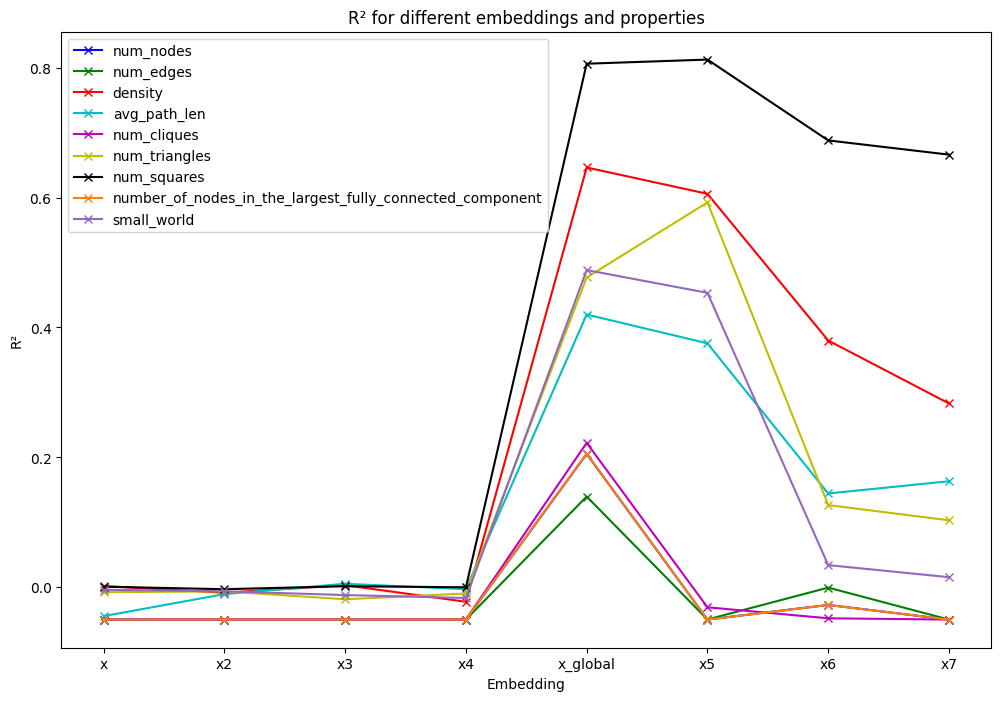

In [30]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component', 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()


node probe for the first layers

In [ ]:
# based on compute_graph_properties() we do compute_graph_node_properties()
def compute_graph_node_properties(data):
    

    